# Data exploration of data in timestream db


## Initialization


In [220]:
import awswrangler as wr
import pandas as pd
import scipy.signal as signal
import seaborn as sns
from dotenv import load_dotenv

%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(16,9)})
sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context("paper")
load_dotenv()


True

## Data retrieval


In [221]:
df = wr.timestream.query('SELECT * FROM "when-to-water"."sensor-data"')
count_retrieved = len(df)
print(f"Retrived {count_retrieved} records")
df.drop_duplicates(inplace=True)
print(f"Dropped {count_retrieved - len(df)} duplicates")
df["time"] = pd.to_datetime(df["time"])
df.sort_values(by="time")
df_counts = df.groupby(["SensorName", "measure_name", df["time"].dt.floor('d')]).size().reset_index(name="count")
df_counts = df_counts.groupby(["SensorName"]).median().rename(columns={"count": "median records per day"})
print(df_counts)
df_max = df.groupby(["SensorName", "measure_name", df["time"].dt.floor('d')]).max()

Retrived 7363 records
Dropped 0 duplicates
            median records per day
SensorName                        
PWS_1                          9.0
PWS_2                          9.0
PWS_3                          9.0


### Transformations


In [222]:

df_soil_moisture = df[df["measure_name"] == "soil_moisture"].rename(columns={"measure_value::double": "soil moisture in %"})
df_soil_moisture_PWS_1 = df_soil_moisture[df_soil_moisture["SensorName"] == "PWS_1"].copy()
df_soil_moisture_PWS_1["soil moisture in %"] = df_soil_moisture_PWS_1["soil moisture in %"].rolling(5).mean()
df_soil_moisture_PWS_1.reset_index(inplace=True)
PWS_1_valleys = signal.find_peaks(-df_soil_moisture_PWS_1["soil moisture in %"], distance=3, prominence=3, width=5)[0]
df_soil_moisture_PWS_1["valley"] = df_soil_moisture_PWS_1.index.isin(PWS_1_valleys)
df_soil_moisture_PWS_2 = df_soil_moisture[df_soil_moisture["SensorName"] == "PWS_2"].copy()
df_soil_moisture_PWS_2["soil moisture in %"] = df_soil_moisture_PWS_2["soil moisture in %"].rolling(5).mean()
df_soil_moisture_PWS_2.reset_index(inplace=True)
PWS_2_valleys = signal.find_peaks(-df_soil_moisture_PWS_2["soil moisture in %"], distance=3, prominence=3, width=5)[0]
df_soil_moisture_PWS_2["valley"] = df_soil_moisture_PWS_2.index.isin(PWS_2_valleys)
df_soil_moisture_PWS_3 = df_soil_moisture[df_soil_moisture["SensorName"] == "PWS_3"].copy()
df_soil_moisture_PWS_3["soil moisture in %"] = df_soil_moisture_PWS_3["soil moisture in %"].rolling(5).mean()
df_soil_moisture_PWS_3.reset_index(inplace=True)
PWS_3_valleys = signal.find_peaks(-df_soil_moisture_PWS_3["soil moisture in %"], distance=3, prominence=3, width=5)[0]
df_soil_moisture_PWS_3["valley"] = df_soil_moisture_PWS_3.index.isin(PWS_3_valleys)
df_soil_moisture = pd.concat([df_soil_moisture_PWS_1, df_soil_moisture_PWS_2, df_soil_moisture_PWS_3]).reset_index()
df_valleys = df_soil_moisture[df_soil_moisture["valley"] == True].reindex(["time", "SensorName"], axis=1)


## Plots


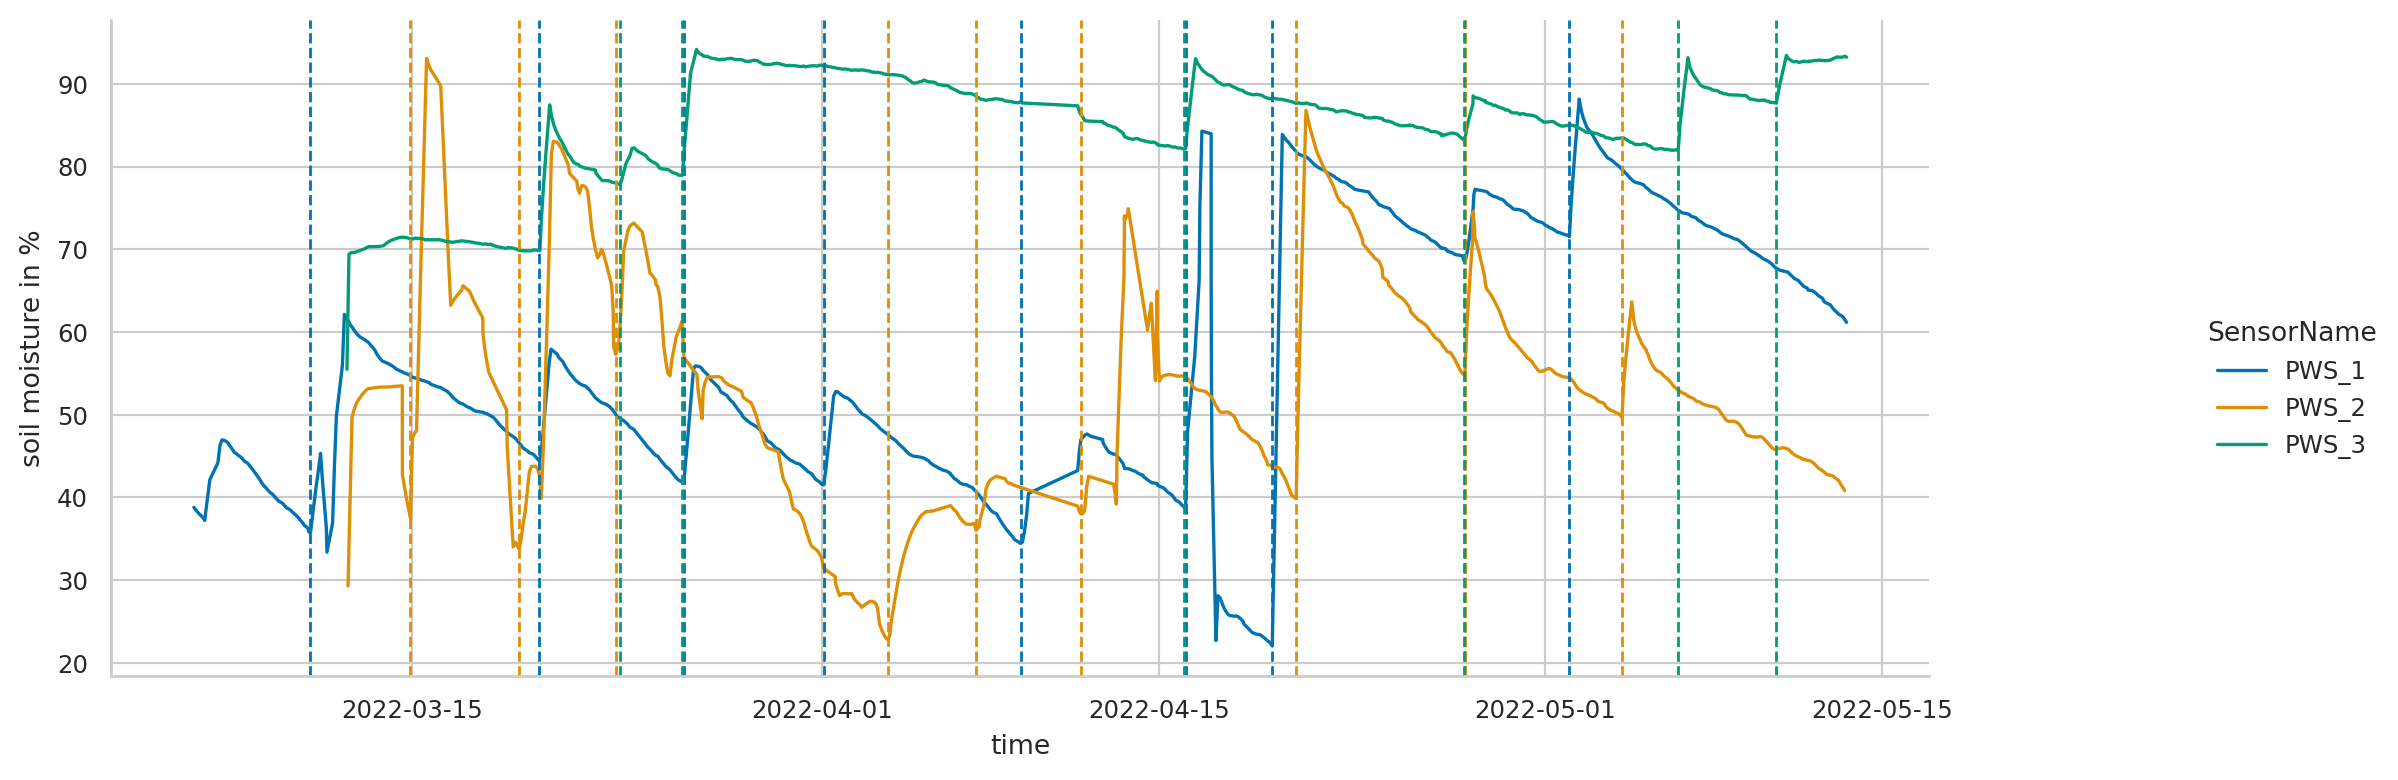

In [223]:
plot = sns.relplot(x="time", y="soil moisture in %", hue="SensorName", data=df_soil_moisture, palette="colorblind", kind="line")
plot.figure.set_size_inches(12, 4)
colors = {
    "PWS_1": sns.palettes.color_palette("colorblind")[0],
    "PWS_2": sns.palettes.color_palette("colorblind")[1],
    "PWS_3": sns.palettes.color_palette("colorblind")[2]
}
for time, sensor_name in zip(df_valleys['time'], df_valleys['SensorName']):
    plot.refline(x = time,
            color = colors.get(sensor_name),
            lw = 1)

sns.despine()